In [44]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy
import scipy.stats as ss
from scipy.stats import mannwhitneyu
from tqdm.auto import tqdm

In [34]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-berezin-33/Statistics/hw_bootstrap.csv', sep=';', decimal=',')

In [38]:
df

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control
...,...,...,...
995,996,1000.000000,Treatment
996,997,1200.000000,Treatment
997,998,1500.000000,Treatment
998,999,2000.000000,Treatment


In [39]:
df_control = df.query('experimentVariant == "Control"')

In [40]:
df_test = df.query('experimentVariant == "Treatment"')

experimentVariant
Control    AxesSubplot(0.125,0.125;0.775x0.755)
Name: value, dtype: object

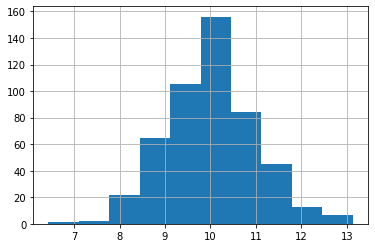

In [63]:
# Проверка распределения
df_control.groupby('experimentVariant')['value'].hist()

experimentVariant
Treatment    AxesSubplot(0.125,0.125;0.775x0.755)
Name: value, dtype: object

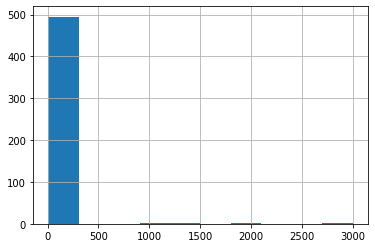

In [64]:
# Проверка распределения
df_test.groupby('experimentVariant')['value'].hist()

#### Т-тест

In [43]:
ss.ttest_ind(df_test['value'], df_control['value'])

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

#### U-тест


In [47]:
mannwhitneyu(df_test['value'], df_control['value'], alternative='two-sided')

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

#### Бутстрап средних


In [61]:
# по Среднему
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}


booted_data = get_bootstrap(df_test['value'], df_control['value'])
booted_data["p_value"]

0.040177407897397655

In [70]:
# по Медиане 
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}


booted_data = get_bootstrap(df_test['value'], df_control['value'])
booted_data["p_value"]

0.9350152677114619

Для начала посмотрим на распределение наших данных. На графиках видно что контрольная группа имеет нормальное распределение, а тестовая группа, наоборот имеет длинный хвост с права и смещена в левую сторну, что говорит нам о не нормальном распределении. Ввиду того что мы не знаем, как именно собирались данные и действительно ли полученные выбросы, являются выбросами, мы не будем их удалять из нашей выборки.

##### В нашем случае нулевая гипотеза звучала так: 
- H0: Разницы между тестовой и контрольной группами нет
- H1: Разница между тестовой и контрольной группами есть

В нашем случае p-уровень значимости был равен 0.05, что означает, если мы получим значение меньше заданного то нулевая гипотеза будет отклонена, а это значит что мы примем Н1. Если p-value привысит заданные значение, то мы примем Н0.

После проведения трех тестов мы получили следующие результаты: 

##### Бутстрап средних
- p-value равно 0.04
Используемый тест позволяет отклонить Н0, т.к. полученный p-уровень значимости оказался ниже заданного.  

##### Бутстрап медиан
- p-value равно 0.94
Используемый тест позволяет отклонить Н1, т.к. полученный p-уровень значимости оказался выше заданного.  

##### U-тест
- p-value равно 0.86
Используемый тест позволяет отклонить Н1, т.к. полученный p-уровень значимости оказался выше заданного.  

##### Т-тест
- p-value равно 0.04
Используемый тест позволяет отклонить Н0, т.к. полученный p-уровень значимости оказался ниже заданного. 
